In [1]:
import sys
import math
import uproot
import operator
import numpy as np
import ROOT  as r
import sklearn.preprocessing
import matplotlib.pyplot as plt
from   scipy.optimize    import leastsq
from   scipy             import stats
from   datetime          import datetime

Welcome to JupyROOT 6.22/00


In [2]:
def deltaphi(e_phi, m_phi) :
    d_phi =  e_phi - m_phi
    if (d_phi >  np.pi) : d_phi -= 2*np.pi
    if (d_phi < -np.pi) : d_phi += 2*np.pi
    return d_phi

In [3]:
def dR(e_phi, e_eta, m_phi, m_eta) :
    d_eta = abs(e_eta - m_eta)
    d_phi = deltaphi(e_phi, m_phi)
    return np.sqrt(d_phi**2 + d_eta**2)

In [4]:
def Convertnuto4vec(nu, i, j):
    neutrino = ROOT.TLorentzVector()
    Px = nu[i][j][0]
    Py = nu[i][j][1]
    Pz = nu[i][j][2]
    E  = math.sqrt(Px**2 + Py**2 + Pz**2)
    neutrino.SetPxPyPzE(Px,Py,Pz,E)
    return neutrino

In [5]:
# Read in gen level m_lb, remove the nans and then make a density histogram
m_lb     = np.loadtxt('../txt_files/m_lb_2016.txt')
mask     = np.isnan(m_lb)
m_lb_red = m_lb[~mask]
ns, bins = np.histogram(m_lb_red[m_lb_red < 200], density=True, bins=200)

# Function to return event top reco weight calculated from the gen level m_lb distribution
def get_mlb_weight(lv_lepton, lv_jet) :
    
    reco_m_lb  = (lv_lepton + lv_jet).M()
    evt_weight = h_mbl_w.GetBinContent(h_mbl_w.FindBin(reco_m_lb))
    return evt_weight/100000000

    '''    
    for i in range(len(bins) - 1) :
        if reco_m_lb > bins[-1] : 
            weight = ns[-1]
            continue
        elif reco_m_lb < bins[0]  : 
            weight = ns[ 0]
            continue
        elif reco_m_lb > bins[i]  and reco_m_lb < bins[i+1] : 
            weight = ns[i]
            
    return weight
    '''

In [6]:
import ROOT
dataFile      = ROOT.TFile("KinReco_input.root","OPEN")

h_jetAngleRes = dataFile.Get("KinReco_d_angle_jet_step7")
h_lepAngleRes = dataFile.Get("KinReco_d_angle_lep_step7")
h_jetEres     = dataFile.Get("KinReco_fE_jet_step7")
h_lepEres     = dataFile.Get("KinReco_fE_lep_step7")
h_mbl_w       = dataFile.Get("KinReco_mbl_true_step0")
h_wmass       = dataFile.Get("KinReco_W_mass_step0")

In [7]:
# Gets a mean solution from the smeared tops 
# Takes as input the vector of top lorentzvectors, vector of weights and assumed top mass
# Similar to https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction_MeanSol.cc

def get_mean_sol(vlv_top, v_weight, top_mass) :
    px_sum = 0
    py_sum = 0
    pz_sum = 0
    
    #Weighted sum (weights according to the m_lb generator distribution)
    for i in range(len(vlv_top)) :
        px_sum = px_sum + v_weight[i] * vlv_top[i].Px()
        py_sum = py_sum + v_weight[i] * vlv_top[i].Py()
        pz_sum = pz_sum + v_weight[i] * vlv_top[i].Pz()
    
    # Mean top momentum    
    px_mean  = px_sum / sum(v_weight)
    py_mean  = py_sum / sum(v_weight)
    pz_mean  = pz_sum / sum(v_weight)
    en_mean  = np.sqrt((px_mean**2 + py_mean**2 + pz_mean**2) + top_mass**2) # -,-,-,+ metric
    
    top_mean = ROOT.TLorentzVector()
    top_mean.SetPx(px_mean)
    top_mean.SetPy(py_mean)
    top_mean.SetPz(pz_mean)
    top_mean.SetE(en_mean)
    
    return top_mean

In [8]:
# Implemented from https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction.cc

def angle_rot(alpha, e, vect_sm) :                       # alpha should be passed, vect_sm is the smeared 4 vector to returned by reference
    
    #if abs(vect_sm.Px()) < e  : vect_sm.setPx(0)
    #if abs(vect_sm.Py()) < e  : vect_sm.setPy(0)
    #if abs(vect_sm.Pz()) < e  : vect_sm.setPz(0)
    
    #alpha = np.random.normal(0, 1)                      # should be related to vect_sm angular resolution
    phi   = 2 * np.pi * np.random.uniform(-1 , 1)   
    pz_1  = vect_sm.Vect().Mag() * np.cos(alpha)
    px_1  = vect_sm.Vect().Mag() * np.sin(alpha) * np.sin(phi)
    py_1  = vect_sm.Vect().Mag() * np.sin(alpha) * np.cos(phi)
    
    if (vect_sm.Py() != 0 or vect_sm.Pz() != 0) :
        d = np.sqrt(vect_sm.Pz()**2 + vect_sm.Py()**2)
        p = vect_sm.Vect().Mag()
        
        x1 = d/p 
        y1 = 0
        z1 = vect_sm.Px() / p
        
        x2 = -(vect_sm.Px() * vect_sm.Py()) / (d * p)
        y2 =   vect_sm.Pz() / d
        z2 =   vect_sm.Py() / p 
        
        x3 = -(vect_sm.Px() * vect_sm.Pz()) / (d * p)
        y3 = - vect_sm.Py() / d
        z3 =   vect_sm.Pz() / p     
        
        vect_sm.SetPx(x1*px_1 + y1*py_1 + z1*pz_1)
        vect_sm.SetPy(x2*px_1 + y2*py_1 + z2*pz_1)
        vect_sm.SetPz(x3*px_1 + y3*py_1 + z3*pz_1)
        vect_sm.SetE(vect_sm.E())
        
        
    if (vect_sm.Px()==0 and vect_sm.Py()==0 and vect_sm.Pz()==0):
        vect_sm.SetPx(vect_sm.Px())
        vect_sm.SetPy(vect_sm.Py())
        vect_sm.SetPz(vect_sm.Pz())
        vect_sm.SetE(vect_sm.E())
    
    if (vect_sm.Px()!=0 and vect_sm.Py()==0 and vect_sm.Pz()==0) : 
        vect_sm.SetPx(pz_1)
        vect_sm.SetPy(px_1)
        vect_sm.SetPz(py_1)
        vect_sm.SetE(vect_sm.E())

In [9]:
# Implemented from https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction.cc

def try_smear(jet1, jet2, lep1, lep2, metx, mety, evt_idx) :
    
    v_weights    = []
    vlv_tops     = []
    vlv_antitops = []
    vlv_nus      = []
    vlv_nubars   = []
    
    if  ( ((lep1 + jet1).M() > 180) or ((jet2 + lep2).M() > 180) ) : 
        zero_lv = ROOT.TLorentzVector()  
        return -999, zero_lv, zero_lv, zero_lv, zero_lv, sum(v_weights)
    
    # Define met, not sure what Vx is
    met     = ROOT.TVector3(metx, mety ,0)
    vX_reco = - jet1.Vect() - jet2.Vect() - lep1.Vect() - lep2.Vect() - met
    
    for i in range(100) :
        
        met_sm  = ROOT.TLorentzVector()
        jet1_sm = ROOT.TLorentzVector(jet1)
        jet2_sm = ROOT.TLorentzVector(jet2)
        lep1_sm = ROOT.TLorentzVector(lep1)
        lep2_sm = ROOT.TLorentzVector(lep2)
        
        metV3_sm = ROOT.TVector3()
        
        # Jet energy based smearing 
        fB1 = h_jetEres.GetRandom()         # From Jet Energy Resolution    
        xB1 = np.sqrt((fB1**2 * jet1_sm.E()**2 - jet1_sm.M2()) / (jet1_sm.P() ** 2))

        jet1_sm.SetXYZT(jet1_sm.Px()*xB1, jet1_sm.Py()*xB1, jet1_sm.Pz()*xB1, jet1_sm.E()*fB1)
        angle_rot(h_jetAngleRes.GetRandom(), 0.001, jet1_sm)

        fB2 = h_jetEres.GetRandom()         # From Jet Energy Resolution  
        xB2 = np.sqrt((fB2**2 * jet2_sm.E()**2  - jet2_sm.M2()) / (jet2_sm.P() ** 2))

        jet2_sm.SetXYZT(jet2_sm.Px()*xB2, jet2_sm.Py()*xB2, jet2_sm.Pz()*xB2, jet2_sm.E()*fB2)
        angle_rot(h_jetAngleRes.GetRandom(), 0.001, jet2_sm)

        # Lepton energy based smearing 
        fL1 = h_lepEres.GetRandom()         # From Lep Energy Resolution           
        xL1 = np.sqrt((fL1**2 * lep1_sm.E()**2  - lep1_sm.M2()) / (lep1_sm.P() ** 2))

        lep1_sm.SetXYZT(lep1_sm.Px()*xB1, lep1_sm.Py()*xB1, lep1_sm.Pz()*xB1, lep1_sm.E()*fB1)
        angle_rot(h_lepAngleRes.GetRandom(), 0.001, lep1_sm)

        #fL2 = np.random.uniform(low= 1.0, high=1.02) # From Lep Energy Resolution,
        fL2 = np.random.normal(1.0, 0.03)  
        xL2 = np.sqrt((fL2**2 * lep2_sm.E()**2  - lep2_sm.M2()) / (lep2_sm.P() ** 2))

        lep2_sm.SetXYZT(lep2_sm.Px()*xB2, lep2_sm.Py()*xB2, lep2_sm.Pz()*xB2, lep2_sm.E()*fB2)
        angle_rot(h_lepAngleRes.GetRandom(), 0.001, lep2_sm)

        # Adjust MET so that it is still balanced
        metV3_sm = -jet1_sm.Vect() - jet2_sm.Vect() - lep1_sm.Vect() - lep2_sm.Vect()- vX_reco
        met_sm.SetXYZM(metV3_sm.Px(),metV3_sm.Py(),0,0)

        #Maybe see if a solution exists or not
        try    :
            d       = doubleNeutrinoSolutions(jet1_sm, jet2_sm, lep1_sm, lep2_sm, met_sm.Px(), met_sm.Py())
            nu1     = Convertnuto4vec(d.nunu_s, 0, 0)
            nubar1  = Convertnuto4vec(d.nunu_s, 0, 1)
            
            top1    = jet1_sm + lep1_sm + nu1
            top2    = jet2_sm + lep2_sm + nubar1
            
            if (len(d.nunu_s) >= 2) :
                nu2     = Convertnuto4vec(d.nunu_s, 1, 0)
                nubar2  = Convertnuto4vec(d.nunu_s, 1, 1)
    
                top3    =  jet1_sm + lep1_sm + nu2
                top4    =  jet2_sm + lep2_sm + nubar2
            
                deta_1  = abs(top1.Eta() - tt_gen_top_eta[evt_idx])
                deta_2  = abs(top2.Eta() - tt_gen_tbar_eta[evt_idx])

                deta_3  = abs(top3.Eta() - tt_gen_top_eta[evt_idx])
                deta_4  = abs(top4.Eta() - tt_gen_tbar_eta[evt_idx])
                
                if (deta_3 + deta_4) < (deta_1 + deta_2) :
                    nu_final    = nu2
                    nubar_final = nubar2
                    top_final   = jet1_sm + lep1_sm + nu2
                    atop_final  = jet2_sm + lep2_sm + nubar2
                    
                else : 
                    nu_final    = nu1
                    nubar_final = nubar1
                    top_final   = jet1_sm + lep1_sm + nu1
                    atop_final  = jet2_sm + lep2_sm + nubar1
                    
            else :
                nu_final    = nu1
                nubar_final = nubar1
                top_final   = top1
                atop_final  = top2
                
            evt_w = get_mlb_weight(jet1_sm, lep1_sm) * get_mlb_weight(jet2_sm, lep2_sm)
            
            v_weights.append(evt_w)
            vlv_nus.append(nu_final)
            vlv_nubars.append(nubar_final)
            vlv_tops.append(top_final)
            vlv_antitops.append(atop_final)
            
        except np.linalg.LinAlgError : pass
        
    if len(v_weights) == 0 : 
        zero_lv = ROOT.TLorentzVector()   
        return -999, zero_lv, zero_lv, zero_lv, zero_lv, sum(v_weights)
        
    else :
        mean_top_sol     = get_mean_sol(vlv_tops    , v_weights, 172.5)
        mean_antitop_sol = get_mean_sol(vlv_antitops, v_weights, 172.5)
        mean_nu_sol      = get_mean_sol(vlv_nus     , v_weights, 0)
        mean_nubar_sol   = get_mean_sol(vlv_nubars  , v_weights, 0)
        ttbar_mass       = (mean_top_sol + mean_antitop_sol).M()
        
        return ttbar_mass, mean_top_sol, mean_antitop_sol, mean_nu_sol, mean_nubar_sol, sum(v_weights)

In [10]:
mT = 172.5   # GeV : top quark mass
mW = 80.385  # GeV : W boson mass
mN = 0       # GeV : neutrino mass


def UnitCircle():
    '''Unit circle in extended representation'''
    return np.diag([1, 1, -1])


def cofactor(A, i, j):
    '''Cofactor[i,j] of 3x3 matrix A'''
    a = A[not i:2 if i==2 else None:2 if i==1 else 1,
          not j:2 if j==2 else None:2 if j==1 else 1]
    return (-1)**(i+j) * (a[0,0]*a[1,1] - a[1,0]*a[0,1])


def R(axis, angle):
    '''Rotation matrix about x(0),y(1), or z(2) axis'''
    c, s = math.cos(angle), math.sin(angle)
    R = c * np.eye(3)
    for i in [-1, 0, 1]:
        R[(axis-i) % 3, (axis+i) % 3] = i*s + (1 - i*i)
    return R


def Derivative():
    '''Matrix to differentiate [cos(t),sin(t),1]'''
    return R(2, math.pi / 2).dot(np.diag([1, 1, 0]))


def multisqrt(y):
    '''Valid real solutions to y=x*x'''
    return ([] if y < 0 else
            [0] if y == 0 else
            (lambda r: [-r, r])(math.sqrt(y)))


def factor_degenerate(G, zero=0):
    '''Linear factors of degenerate quadratic polynomial'''
    if G[0,0] == 0 == G[1,1]:
        return [[G[0,1], 0, G[1,2]],
                [0, G[0,1], G[0,2] - G[1,2]]]

    swapXY = abs(G[0,0]) > abs(G[1,1])
    Q = G[(1,0,2),][:,(1,0,2)] if swapXY else G
    Q /= Q[1,1]
    q22 = cofactor(Q, 2, 2)

    if -q22 <= zero:
        lines = [[Q[0,1], Q[1,1], Q[1,2]+s]
                 for s in multisqrt(-cofactor(Q, 0, 0))]
    else:
        x0, y0 = [cofactor(Q, i, 2) / q22 for i in [0, 1]]
        lines = [[m, Q[1,1], -Q[1,1]*y0 - m*x0]
                 for m in [Q[0,1] + s
                           for s in multisqrt(-q22)]]

    return [[L[swapXY],L[not swapXY],L[2]] for L in lines]


def intersections_ellipse_line(ellipse, line, zero=1e-12):
    '''Points of intersection between ellipse and line'''
    _,V = np.linalg.eig(np.cross(line,ellipse).T)
    sols = sorted([(v.real / v[2].real,
                    np.dot(line,v.real)**2 +
                    np.dot(v.real,ellipse).dot(v.real)**2)
                    for v in V.T],
                    key=lambda s: s[1])[:2]
    return [s for s, k in sols if k < zero]


def intersections_ellipses(A, B, returnLines=False):
    '''Points of intersection between two ellipses'''
    LA = np.linalg
    if abs(LA.det(B)) > abs(LA.det(A)): A,B = B,A
    e = next(e.real for e in LA.eigvals(LA.inv(A).dot(B))
             if not e.imag)
    lines = factor_degenerate(B - e*A)
    points = sum([intersections_ellipse_line(A,L)
                  for L in lines],[])
    return (points,lines) if returnLines else points


class nuSolutionSet(object):
    '''Definitions for nu analytic solution, t->b,mu,nu'''

    def __init__(self, b, mu, mW2=mW**2, mT2=mT**2, mN2=mN**2):
        
        c = r.Math.VectorUtil.CosTheta(b,mu)
        s = math.sqrt(1-c**2)

        x0p = - (mT2 - mW2 - b.M2()) / (2*b.E())
        x0  = - (mW2 - mu.M2() - mN2) / (2*mu.E())

        Bb, Bm = b.Beta(), mu.Beta()

        Sx = (x0 * Bm - mu.P()*(1-Bm**2)) / Bm**2
        Sy = (x0p / Bb - c * Sx) / s

        w  = (Bm / Bb - c) / s
        w_ = (-Bm / Bb - c) / s

        Om2  = w**2 + 1 - Bm**2
        eps2 = (mW2 - mN2) * (1 - Bm**2)
        x1   = Sx - (Sx+w*Sy) / Om2
        y1   = Sy - (Sx+w*Sy) * w / Om2
        Z2   = x1**2 * Om2 - (Sy-w*Sx)**2 - (mW2-x0**2-eps2)
        Z    = math.sqrt(max(0, Z2))

        for item in ['b','mu','c','s','x0','x0p',
                     'Sx','Sy','w','w_','x1','y1',
                     'Z','Om2','eps2','mW2']:
            setattr(self, item, eval(item))

    @property
    def K(self):
        '''Extended rotation from F' to F coord.'''
        return np.array([[self.c, -self.s, 0, 0],
                         [self.s,  self.c, 0, 0],
                         [     0,       0, 1, 0],
                         [     0,       0, 0, 1]])

    @property
    def A_mu(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        B2   = self.mu.Beta()**2
        SxB2 = self.Sx * B2
        F    = self.mW2 - self.x0**2 - self.eps2
        return np.array([[1-B2, 0, 0, SxB2],
                         [   0, 1, 0,    0],
                         [   0, 0, 1,    0],
                         [SxB2, 0, 0,    F]])

    @property
    def A_b(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        K, B = self.K, self.b.Beta()
        mW2, x0p = self.mW2, self.x0p
        A_b_ = np.array([[1-B*B,  0,  0,      B*x0p],
                         [    0,  1,  0,          0],
                         [    0,  0,  1,          0],
                         [B*x0p,  0,  0, mW2-x0p**2]])
        return K.dot(A_b_).dot(K.T)

    @property
    def R_T(self):
        '''Rotation from F coord. to laboratory coord.'''
        b_xyz = self.b.X(), self.b.Y(), self.b.Z()
        R_z   = R(2, -self.mu.Phi())
        R_y   = R(1, 0.5*math.pi - self.mu.Theta())
        R_x   = next(R(0,-math.atan2(z,y))
                   for x,y,z in (R_y.dot(R_z.dot(b_xyz)),))
        return R_z.T.dot(R_y.T.dot(R_x.T))

    @property
    def H_tilde(self):
        '''Transformation of t=[c,s,1] to p_nu: F coord.'''
        x1, y1, p = self.x1, self.y1, self.mu.P()
        Z, w, Om  = self.Z , self.w , math.sqrt(self.Om2)
        return np.array([[  Z/Om, 0, x1-p],
                         [w*Z/Om, 0,   y1],
                         [     0, Z,    0]])

    @property
    def H(self):
        '''Transformation of t=[c,s,1] to p_nu: lab coord.'''
        return self.R_T.dot(self.H_tilde)

    @property
    def H_perp(self):
        '''Transformation of t=[c,s,1] to pT_nu: lab coord.'''
        return np.vstack([self.H[:2], [0, 0, 1]])

    @property
    def N(self):
        '''Solution ellipse of pT_nu: lab coord.'''
        HpInv = np.linalg.inv(self.H_perp)
        return HpInv.T.dot(UnitCircle()).dot(HpInv)


class doubleNeutrinoSolutions(object):
    '''Solution pairs of neutrino momenta, tt -> leptons'''
    def __init__(self, b, b_ , mu, mu_, metX, metY, mW2=mW**2, mT2=mT**2):
        
        self.solutionSets = [nuSolutionSet(B, M, mW2, mT2)
                             for B,M in zip((b,b_),(mu,mu_))]

        V0     = np.outer([metX, metY, 0], [0, 0, 1])
        self.S = V0 - UnitCircle()

        N, N_ = [ss.N for ss in self.solutionSets]
        n_    = self.S.T.dot(N_).dot(self.S)

        v  = intersections_ellipses(N, n_)
        v_ = [self.S.dot(sol) for sol in v]

        if not v and leastsq:
            es  = [ss.H_perp for ss in self.solutionSets]
            met = np.array([metX, metY, 1])

            def nus(ts):
                return tuple(e.dot([math.cos(t), math.sin(t), 1])
                             for e, t in zip(es, ts))

            def residuals(params):
                return sum(nus(params), -met)[:2]

            ts,_  = leastsq(residuals, [0, 0], ftol=5e-5, epsfcn=0.01)
            v, v_ = [[i] for i in nus(ts)]
      
        for k, v in {'perp': v, 'perp_': v_, 'n_': n_}.items():
            setattr(self, k, v)

    @property
    def nunu_s(self):
        '''Solution pairs for neutrino momenta'''
        K, K_ = [ss.H.dot(np.linalg.inv(ss.H_perp))
                 for ss in self.solutionSets]
        return [(K.dot(s), K_.dot(s_))
                for s, s_ in zip(self.perp, self.perp_)]

In [11]:
def Convertnuto4vec_new(nu):
    nu_arr = []
    # Solution number, nuetrino number, Px/y/z
    for i in range(len(nu)):
        for j in range(2): 
            neutrino = ROOT.TLorentzVector()
            Px = nu[i][j][0]
            Py = nu[i][j][1]
            Pz = nu[i][j][2]
            E  = math.sqrt(Px**2 + Py**2 + Pz**2)
            neutrino.SetPxPyPzE(Px,Py,Pz,E)
            nu_arr.append(neutrino)
    return nu_arr

In [12]:
tt_ptr     = uproot.open('/Volumes/Seagate Portable Media 1/CMS_data/ee_with_METphi.root')['ttBar_treeVariables_step8']

tt_MET     = tt_ptr['met_pt'].array()
tt_MET_phi = tt_ptr['met_phi'].array()

tt_l_pt    = tt_ptr['l_pt'].array()
tt_l_eta   = tt_ptr['l_eta'].array()
tt_l_phi   = tt_ptr['l_phi'].array()

tt_b_pt    = tt_ptr['b_pt'].array()
tt_b_eta   = tt_ptr['b_eta'].array()
tt_b_phi   = tt_ptr['b_phi'].array()

tt_lbar_pt   = tt_ptr['lbar_pt'].array()
tt_lbar_eta  = tt_ptr['lbar_eta'].array()
tt_lbar_phi  = tt_ptr['lbar_phi'].array()

tt_bbar_pt   = tt_ptr['bbar_pt'].array()
tt_bbar_eta  = tt_ptr['bbar_eta'].array()
tt_bbar_phi  = tt_ptr['bbar_phi'].array()

tt_t_pt    = tt_ptr['top_pt'].array()
tt_t_eta   = tt_ptr['top_rapidity'].array()
tt_t_phi   = tt_ptr['top_phi'].array()

tt_tbar_pt    = tt_ptr['tbar_pt'].array()
tt_tbar_eta   = tt_ptr['tbar_rapidity'].array()
tt_tbar_phi   = tt_ptr['tbar_phi'].array()

In [13]:
tt_gen_top_pt    = tt_ptr['gen_top_pt'].array()
tt_gen_top_eta   = tt_ptr['gen_top_rapidity'].array()
tt_gen_top_phi   = tt_ptr['gen_top_phi'].array()

tt_gen_tbar_pt    = tt_ptr['gen_tbar_pt'].array()
tt_gen_tbar_eta   = tt_ptr['gen_tbar_rapidity'].array()
tt_gen_tbar_phi   = tt_ptr['gen_tbar_phi'].array()

In [14]:
tt_nu_pt    = tt_ptr['nu_pt'].array()
tt_nu_eta   = tt_ptr['nu_eta'].array()
tt_nu_phi   = tt_ptr['nu_phi'].array()

tt_nubar_pt    = tt_ptr['nubar_pt'].array()
tt_nubar_eta   = tt_ptr['nubar_eta'].array()
tt_nubar_phi   = tt_ptr['nubar_phi'].array()

In [15]:
tt_gen_nu_pt    = tt_ptr['gen_nu_pt'].array()
tt_gen_nu_eta   = tt_ptr['gen_nu_eta'].array()
tt_gen_nu_phi   = tt_ptr['gen_nu_phi'].array()

tt_gen_nubar_pt    = tt_ptr['gen_nubar_pt'].array()
tt_gen_nubar_eta   = tt_ptr['gen_nubar_eta'].array()
tt_gen_nubar_phi   = tt_ptr['gen_nubar_phi'].array()

## DOESN'T USE MIN MASS

In [63]:
import ROOT
tt_mass   = []
top_pt    = []
top_eta   = []
top_phi   = []

atop_pt    = []
atop_eta   = []
atop_phi   = []

nu_pt    = []
nu_eta   = []
nu_phi   = []

anu_pt    = []
anu_eta   = []
anu_phi   = []

for i in range (50000) :

    if (i% 1000 == 0):
        print('Processing event :: ' + str(i))
        now = datetime.now()   # Time keeping
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
  
    jet1 = ROOT.TLorentzVector()
    jet2 = ROOT.TLorentzVector()
    lep1 = ROOT.TLorentzVector()
    lep2 = ROOT.TLorentzVector()
    
    top1 = ROOT.TLorentzVector()
    top2 = ROOT.TLorentzVector()
    
    atop1 = ROOT.TLorentzVector()
    atop2 = ROOT.TLorentzVector()
    
    jet1.SetPtEtaPhiM(tt_b_pt[i]   , tt_b_eta[i]   , tt_b_phi[i]   , 4.2)
    jet2.SetPtEtaPhiM(tt_bbar_pt[i], tt_bbar_eta[i], tt_bbar_phi[i], 4.2)
    
    lep1.SetPtEtaPhiM(tt_l_pt[i]   , tt_l_eta[i]   , tt_l_phi[i]   , 0.0)
    lep2.SetPtEtaPhiM(tt_lbar_pt[i], tt_lbar_eta[i], tt_lbar_phi[i], 0.0)
    
    met_x   =  tt_MET[i] * np.cos(tt_MET_phi[i])
    met_y   =  tt_MET[i] * np.sin(tt_MET_phi[i])
    
    m_tt_1, top_p4_1, atop_p4_1, nu_p4_1, nubar_p4_1, sw_1 = try_smear(jet1, jet2, lep2, lep1, met_x, met_y, i)
    m_tt_2, top_p4_2, atop_p4_2, nu_p4_2, nubar_p4_2, sw_2 = try_smear(jet2, jet1, lep2, lep1, met_x, met_y, i)

    if (m_tt_1 == -999  and m_tt_2 == -999) : continue
    
    # Lower mttbar gives correct assignment ?

    if (m_tt_2 == -999) :
        m_tt_final     = m_tt_1
        top_p4_final   = top_p4_1
        atop_p4_final  = atop_p4_1
        nu_p4_final    = nu_p4_1
        nubar_p4_final = nubar_p4_1

    if (m_tt_1 == -999) :
        m_tt_final     = m_tt_2
        top_p4_final   = top_p4_2
        atop_p4_final  = atop_p4_2
        nu_p4_final    = nu_p4_2
        nubar_p4_final = nubar_p4_2
        
    if( (m_tt_1 != -999 and m_tt_2 != -999) and sw_2 <= sw_1) :
        m_tt_final     = m_tt_1
        top_p4_final   = top_p4_1
        atop_p4_final  = atop_p4_1
        nu_p4_final    = nu_p4_1
        nubar_p4_final = nubar_p4_1
    
    if( (m_tt_1 != -999 and m_tt_2 != -999) and sw_1 <= sw_2) :   
        m_tt_final     = m_tt_2
        top_p4_final   = top_p4_2
        atop_p4_final  = atop_p4_2
        nu_p4_final    = nu_p4_2
        nubar_p4_final = nubar_p4_2
        
    tt_mass.append(m_tt_final)
    top_pt.append(top_p4_final.Pt())
    top_eta.append(top_p4_final.Eta())
    top_phi.append(top_p4_final.Phi())
    
    atop_pt.append(atop_p4_final.Pt())
    atop_eta.append(atop_p4_final.Eta())
    atop_phi.append(atop_p4_final.Phi())
    
    nu_pt.append(nu_p4_final.Pt())
    nu_eta.append(nu_p4_final.Eta())
    nu_phi.append(nu_p4_final.Phi())
    
    anu_pt.append(nubar_p4_final.Pt())
    anu_eta.append(nubar_p4_final.Eta())
    anu_phi.append(nubar_p4_final.Phi())


Processing event :: 0
Current Time = 01:12:08


<ipython-input-10-d2c98e6ea2ab>:59: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return [[L[swapXY],L[not swapXY],L[2]] for L in lines]
<ipython-input-9-22e8a20de54f>:31: RuntimeWarning: invalid value encountered in sqrt
  xB1 = np.sqrt((fB1**2 * jet1_sm.E()**2 - jet1_sm.M2()) / (jet1_sm.P() ** 2))
/Users/amandeepsinghbakshi/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/amandeepsinghbakshi/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)
<ipython-input-9-22e8a20de54f>:37: RuntimeWarning: invalid value encountered in sqrt
  xB2 = np.sqrt((fB2**2 * jet2_sm.E()**2  - jet2_sm.M2()) / (jet2_sm.P() ** 2))


Processing event :: 1000
Current Time = 01:19:53
Processing event :: 2000
Current Time = 01:27:45
Processing event :: 3000
Current Time = 01:35:48
Processing event :: 4000
Current Time = 01:42:32
Processing event :: 5000
Current Time = 01:49:04
Processing event :: 6000
Current Time = 01:55:18
Processing event :: 7000
Current Time = 02:01:50
Processing event :: 8000
Current Time = 02:09:28
Processing event :: 9000
Current Time = 02:16:22
Processing event :: 10000
Current Time = 02:24:16
Processing event :: 11000
Current Time = 02:31:47
Processing event :: 12000
Current Time = 02:38:19
Processing event :: 13000
Current Time = 02:44:39
Processing event :: 14000
Current Time = 02:51:01
Processing event :: 15000
Current Time = 02:57:26
Processing event :: 16000
Current Time = 03:03:39
Processing event :: 17000
Current Time = 03:09:47
Processing event :: 18000
Current Time = 03:16:08
Processing event :: 19000
Current Time = 03:22:30
Processing event :: 20000
Current Time = 03:28:49
Processin

In [21]:
len(tt_mass)

10000

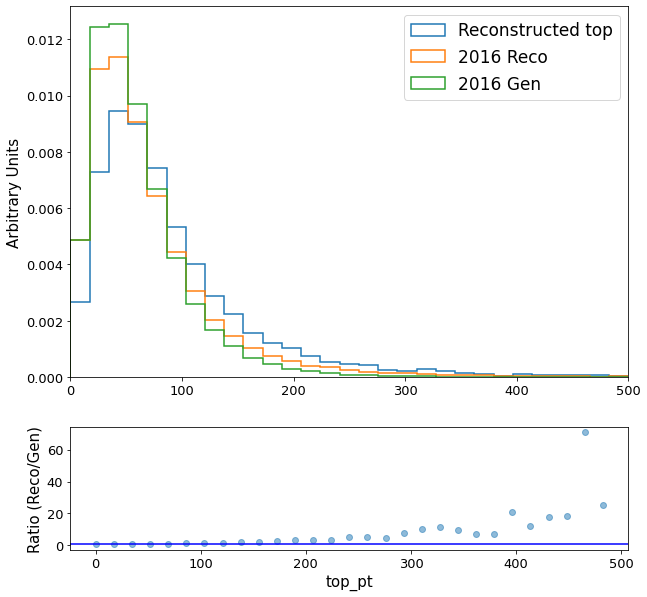

In [25]:
x_low    =  0
x_high   =  500

binning = np.linspace(x_low,x_high, 30)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}

fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(nu_pt, density=True, histtype='step', bins=binning, label='Reconstructed top', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_nu_pt, density=True, histtype='step', bins=binning, label='2016 Reco', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_gen_nu_pt, density=True, histtype='step', bins=binning, label='2016 Gen', linewidth=1.5)

ax1.legend(prop={'size': 17}, loc='upper right')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
        ns1 / ns2,         # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Reco/Gen)', fontsize=15)
ax2.set_xlabel('top_pt', fontsize=15)
#ax2.set_ylim(0.5, 1.5)
#ax2.set_ylim(0, max(ns1/ns2))
#ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

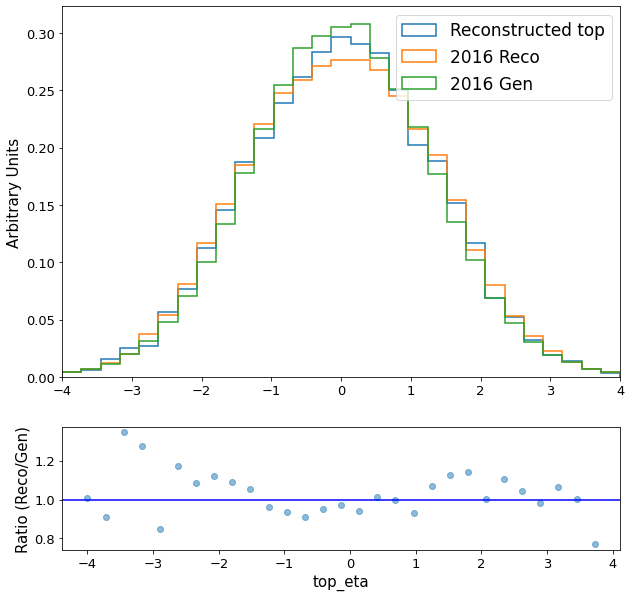

In [24]:
x_low    =  -4
x_high   =   4

binning = np.linspace(x_low,x_high, 30)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}

fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(nu_eta, density=True, histtype='step', bins=binning, label='Reconstructed top', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_nu_eta, density=True, histtype='step', bins=binning, label='2016 Reco', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_gen_nu_eta, density=True, histtype='step', bins=binning, label='2016 Gen', linewidth=1.5)

ax1.legend(prop={'size': 17}, loc='upper right')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
        ns1 / ns2,         # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Reco/Gen)', fontsize=15)
ax2.set_xlabel('top_eta', fontsize=15)
#ax2.set_ylim(0.5, 1.5)
#ax2.set_ylim(0, max(ns1/ns2))
#ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

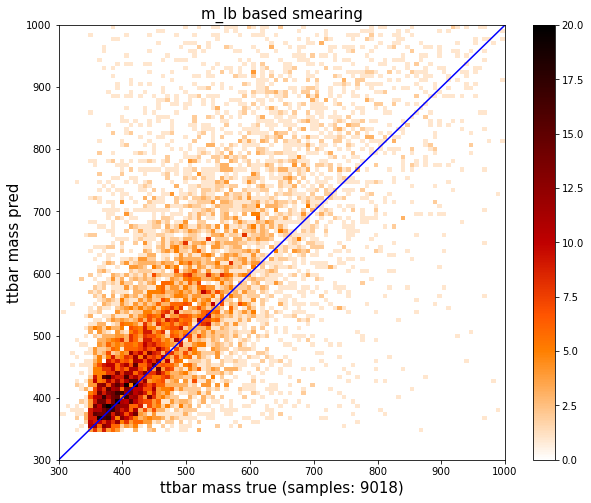

In [29]:
tt_mass    = np.array(tt_mass)
tt_gen_red = gen_m_ttbar[:len(tt_mass)]
mask_reco  = tt_mass < 1000
mask_gen   = tt_gen_red < 1000
mask_fin   = mask_reco & mask_gen
samples    = len(tt_mass[mask_fin])

heatmap,xedges,yedges = np.histogram2d(tt_gen_red[mask_fin], tt_mass[mask_fin],bins=100)
extent  = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.figure(figsize=(10,8))
plt.imshow(heatmap.T ,extent=extent, origin='lower', aspect='auto')
plt.plot([0,2000],[0,2000],color='blue')
plt.set_cmap('gist_heat_r')
plt.xlabel("ttbar mass true (samples: %.i)" %samples, fontsize=15)
plt.ylabel("ttbar mass pred", fontsize=15)
plt.title("m_lb based smearing", fontsize=15)
plt.xlim(300,1000)
plt.ylim(300,1000)
plt.colorbar()
#plt.savefig('ellipse_int_heatmap_min_mass.jpg')

## TEST UNIT

In [137]:
import ROOT 
i  = 41

jet1 = ROOT.TLorentzVector()
jet2 = ROOT.TLorentzVector()
lep1 = ROOT.TLorentzVector()
lep2 = ROOT.TLorentzVector()

top1 = ROOT.TLorentzVector()
top2 = ROOT.TLorentzVector()

atop1 = ROOT.TLorentzVector()
atop2 = ROOT.TLorentzVector()

jet1.SetPtEtaPhiM(tt_b_pt[i]   , tt_b_eta[i]   , tt_b_phi[i]   , 4.2)
jet2.SetPtEtaPhiM(tt_bbar_pt[i], tt_bbar_eta[i], tt_bbar_phi[i], 4.2)

lep1.SetPtEtaPhiM(tt_l_pt[i]   , tt_l_eta[i]   , tt_l_phi[i]   , 0.0)
lep2.SetPtEtaPhiM(tt_lbar_pt[i], tt_lbar_eta[i], tt_lbar_phi[i], 0.0)

met_x   =  tt_MET[i] * np.cos(tt_MET_phi[i])
met_y   =  tt_MET[i] * np.sin(tt_MET_phi[i])

print('MET :: ' +str(tt_MET[i]))

try :
    d = doubleNeutrinoSolutions(jet1, jet2, lep2, lep1, met_x, met_y)
    print('____________________________________')
    print('Mlb score :: ' + str(get_mlb_weight(jet1, lep2) * get_mlb_weight(jet2, lep1)))
    print('____________________________________')
    print('Gen Neutrinos')
    print(tt_gen_nu_pt[i]   , tt_gen_nu_eta[i]   , tt_gen_nu_phi[i])
    print(tt_gen_nubar_pt[i], tt_gen_nubar_eta[i], tt_gen_nubar_phi[i])
    
    print('Reco Neutrinos')
    print(tt_nu_pt[i]   , tt_nu_eta[i]   , tt_nu_phi[i])
    print(tt_nubar_pt[i], tt_nubar_eta[i], tt_nubar_phi[i])
    
    print('')
        
    print('Gen Tops')
    print(tt_gen_top_pt[i] , tt_gen_top_eta[i] , tt_gen_top_phi[i])
    print(tt_gen_tbar_pt[i], tt_gen_tbar_eta[i], tt_gen_tbar_phi[i])
    
    print('Reco Tops')
    
    print(tt_t_pt[i]   , tt_t_eta[i]   , tt_t_phi[i])
    print(tt_tbar_pt[i], tt_tbar_eta[i], tt_tbar_phi[i])

    print('tt_reco_mass :: ' + str(m_ttbar[i]))
    print('tt_gen_mass :: '  + str(gen_m_ttbar[i]))
    print('____________________________________')
    
    neutrino1  = Convertnuto4vec(d.nunu_s, 0 ,0)
    neutrino2  = Convertnuto4vec(d.nunu_s, 0, 1)
    
    print('Mere Neutrinos')
    print(neutrino1.Pt(), neutrino1.Eta(), neutrino1.Phi())
    print(neutrino2.Pt(), neutrino2.Eta(), neutrino2.Phi())
    
    deta_1  = abs(neutrino1.Eta() - tt_gen_nu_eta[i])
    deta_2  = abs(neutrino2.Eta() - tt_gen_nubar_eta[i])
    
    top1 = jet1 + lep2 + neutrino1
    top2 = jet2 + lep1 + neutrino2

    tt_deta_1  = abs(top1.Eta() - tt_gen_top_eta[i])
    tt_deta_2  = abs(top2.Eta() - tt_gen_tbar_eta[i])
    
    print('Mere Tops')
    print(top1.Pt(), top1.Eta(), top1.Phi())
    print(top2.Pt(), top2.Eta(), top2.Phi())
    
    print('ttbar mass  :: ' + str((top1 + top2).M()))
    print('deta :: ' + str((deta_1 + deta_2)))
    print('top deta :: ' + str(tt_deta_1 + tt_deta_2))
    
    if len(d.nunu_s) >= 2 :

        print('____________________________________')
        neutrino3  = Convertnuto4vec(d.nunu_s, 1, 0)
        neutrino4  = Convertnuto4vec(d.nunu_s, 1, 1)
        
        print('Mere sautele Neutrinos')
        print(neutrino3.Pt(), neutrino3.Eta(), neutrino3.Phi())
        print(neutrino4.Pt(), neutrino4.Eta(), neutrino4.Phi())
        
        deta_3  = abs(neutrino3.Eta() - tt_gen_nu_eta[i])
        deta_4  = abs(neutrino4.Eta() - tt_gen_nubar_eta[i])
        
        top3 = jet1 + lep2 + neutrino3
        top4 = jet2 + lep1 + neutrino4

        tt_deta_3  = abs(top3.Eta() - tt_gen_top_eta[i])
        tt_deta_4  = abs(top4.Eta() - tt_gen_tbar_eta[i])
        
        print('Mere sautele Tops')
        
        print(top3.Pt(), top3.Eta(), top3.Phi())
        print(top4.Pt(), top4.Eta(), top4.Phi())
        
        print('ttbar mass  :: ' + str((top3 + top4).M()))   
        print('deta :: ' + str((deta_3 + deta_4)) )
        print('top deta :: ' + str(tt_deta_3 + tt_deta_4))

    print('____________________________________')

except np.linalg.LinAlgError : pass 

print('____________________________________')


try :
    d = doubleNeutrinoSolutions(jet2, jet1, lep2, lep1, met_x, met_y)
    print('____________________________________')
    print('Mlb score :: ' + str(get_mlb_weight(jet2, lep2) * get_mlb_weight(jet1, lep1)))
    print('____________________________________')
    neutrino1  = Convertnuto4vec(d.nunu_s, 0 ,0)
    neutrino2  = Convertnuto4vec(d.nunu_s, 0, 1)

    print('Mere Neutrinos')
    print(neutrino1.Pt(), neutrino1.Eta(), neutrino1.Phi())
    print(neutrino2.Pt(), neutrino2.Eta(), neutrino2.Phi())

    deta_1  = abs(neutrino1.Eta() - tt_gen_nu_eta[i])
    deta_2  = abs(neutrino2.Eta() - tt_gen_nubar_eta[i])

    top1 = jet2 + lep2 + neutrino1
    top2 = jet1 + lep1 + neutrino2

    print('Mere Tops')
    print(top1.Pt(), top1.Eta(), top1.Phi())
    print(top2.Pt(), top2.Eta(), top2.Phi())

    print('ttbar mass  :: ' + str((top1 + top2).M()))
    print('deta :: ' + str((deta_1 + deta_2)))

    if len(d.nunu_s) >= 2 :

        print('____________________________________')
        neutrino3  = Convertnuto4vec(d.nunu_s, 1, 0)
        neutrino4  = Convertnuto4vec(d.nunu_s, 1, 1)

        print('Mere sautele Neutrinos')
        print(neutrino3.Pt(), neutrino3.Eta(), neutrino3.Phi())
        print(neutrino4.Pt(), neutrino4.Eta(), neutrino4.Phi())

        deta_3  = abs(neutrino3.Eta()    - tt_gen_nu_eta[i])
        deta_4  = abs(neutrino4.Eta() - tt_gen_nubar_eta[i])


        top3 = jet2 + lep2 + neutrino3
        top4 = jet1 + lep1 + neutrino4
        print('Mere sautele Tops')
        print(top3.Pt(), top3.Eta(), top3.Phi())
        print(top4.Pt(), top4.Eta(), top4.Phi())
        print('ttbar mass  :: ' + str((top3 + top4).M()))   
        print('deta :: ' + str((deta_3 + deta_4)))
    
except np.linalg.LinAlgError : pass 

MET :: 182.06802
____________________________________
Mlb score :: 3.837463486688689e-06
____________________________________
Gen Neutrinos
189.97142 -0.9421155 1.9338744
144.60406 0.26132062 -3.0789812
Reco Neutrinos
58.815872 2.35628 -2.11771
186.28656 0.45692235 2.2815495

Gen Tops
173.92192 -0.7909277 1.9119303
176.80386 0.17759036 -3.0870593
Reco Tops
135.40843 1.1137359 -1.6690295
295.18378 0.535893 2.2896245
tt_reco_mass :: 538.43555
tt_gen_mass :: 475.2941
____________________________________
Mere Neutrinos
242.56118474935434 -0.0811781436203962 -0.5622703574016845
448.0145259853251 0.4484042061892485 2.6909064101236804
Mere Tops
302.800510950756 -0.09255684136073408 -0.7503249345089805
540.9823115934928 0.5173041961394628 2.6248279674904547
ttbar mass  :: 917.2116025601017
deta :: 1.048020927461812
top deta :: 1.0380847076506234
____________________________________
____________________________________
____________________________________
Mlb score :: 2.5267681253002694e-06
___

<ipython-input-8-d2c98e6ea2ab>:59: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return [[L[swapXY],L[not swapXY],L[2]] for L in lines]


In [40]:
import ROOT

i  = 5

jet1 = ROOT.TLorentzVector()
jet2 = ROOT.TLorentzVector()
lep1 = ROOT.TLorentzVector()
lep2 = ROOT.TLorentzVector()

top1 = ROOT.TLorentzVector()
top2 = ROOT.TLorentzVector()

atop1 = ROOT.TLorentzVector()
atop2 = ROOT.TLorentzVector()

jet1.SetPtEtaPhiM(tt_b_pt[i]   , tt_b_eta[i]   , tt_b_phi[i]   , 4.2)
jet2.SetPtEtaPhiM(tt_bbar_pt[i], tt_bbar_eta[i], tt_bbar_phi[i], 4.2)

lep1.SetPtEtaPhiM(tt_l_pt[i]   , tt_l_eta[i]   , tt_l_phi[i]   , 0.0)
lep2.SetPtEtaPhiM(tt_lbar_pt[i], tt_lbar_eta[i], tt_lbar_phi[i], 0.0)

met_x   =  tt_MET[i] * np.cos(tt_MET_phi[i])
met_y   =  tt_MET[i] * np.sin(tt_MET_phi[i])

mlb_p1 = get_mlb_weight(jet1, lep2)
mlb_p2 = get_mlb_weight(jet2, lep2)

m_tt_1, top_p4_1, atop_p4_1, nu_p4_1, nubar_p4_1, w_1 = try_smear(jet1, jet2, lep2, lep1, met_x, met_y, i)
m_tt_2, top_p4_2, atop_p4_2, nu_p4_2, nubar_p4_2, w_2 = try_smear(jet2, jet1, lep2, lep1, met_x, met_y, i)


print('Gen Neutrinos')
print(tt_gen_nu_pt[i]   , tt_gen_nu_eta[i]   , tt_gen_nu_phi[i])
print(tt_gen_nubar_pt[i], tt_gen_nubar_eta[i], tt_gen_nubar_phi[i])

print('Reco Neutrinos')
print(tt_nu_pt[i]   , tt_nu_eta[i]   , tt_nu_phi[i])
print(tt_nubar_pt[i], tt_nubar_eta[i], tt_nubar_phi[i])

print('')

print('Gen Tops')
print(tt_gen_top_pt[i] , tt_gen_top_eta[i] , tt_gen_top_phi[i])
print(tt_gen_tbar_pt[i], tt_gen_tbar_eta[i], tt_gen_tbar_phi[i])

print('Reco Tops')

print(tt_t_pt[i]   , tt_t_eta[i]   , tt_t_phi[i])
print(tt_tbar_pt[i], tt_tbar_eta[i], tt_tbar_phi[i])

print('tt_reco_mass :: ' + str(m_ttbar[i]))
print('tt_gen_mass :: '  + str(gen_m_ttbar[i]))
print('____________________________________')

print('Sum of weights :: ' + str(w_1))
print('Mere Nuetrinos')
print(nu_p4_1.Pt()   , nu_p4_1.Eta()   , nu_p4_1.Phi())
print(nubar_p4_1.Pt(), nubar_p4_1.Eta(), nubar_p4_1.Phi())

print('Mere Tops')
print(top_p4_1.Pt() , top_p4_1.Eta() , top_p4_1.Phi())
print(atop_p4_1.Pt(), atop_p4_1.Eta(), atop_p4_1.Phi())

print('mttbar :: ' + str(m_tt_1))
print('____________________________________')

print('Sum of weights :: ' + str(w_2))
print('Mere Nuetrinos')
print(nu_p4_2.Pt()   , nu_p4_2.Eta()   , nu_p4_2.Phi())
print(nubar_p4_2.Pt(), nubar_p4_2.Eta(), nubar_p4_2.Phi())

print('Mere Tops')
print(top_p4_2.Pt() , top_p4_2.Eta() , top_p4_2.Phi())
print(atop_p4_2.Pt(), atop_p4_2.Eta(), atop_p4_2.Phi())

print('mttbar :: ' + str(m_tt_2))

<ipython-input-10-d2c98e6ea2ab>:59: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return [[L[swapXY],L[not swapXY],L[2]] for L in lines]


Gen Neutrinos
85.38159 -0.27135062 2.1024325
16.896332 -2.0725744 -2.1089394
Reco Neutrinos
89.17536 -0.17673075 2.1493123
11.340672 1.9133848 1.7539554

Gen Tops
151.60442 0.056527305 2.696742
42.700787 -0.65433586 0.57300895
Reco Tops
155.02312 0.07505889 2.673657
168.0074 0.83733726 -0.6199429
tt_reco_mass :: 506.70197
tt_gen_mass :: 408.62708
____________________________________
Sum of weights :: 0.000615095367682653
Mere Nuetrinos
124.72916354812115 -0.26719376211625356 2.690498314330102
57.557632972273865 1.0886198824739919 0.40347708008587563
Mere Tops
210.2234495607144 -0.0003779269590727067 2.919410012369895
232.3119315603966 1.0638534725066302 -0.4526677491115518
mttbar :: 616.4129410739974
Chi square :: 58.61903366715973
____________________________________
Sum of weights :: 0
Mere Nuetrinos
0.0 0.0 0.0
0.0 0.0 0.0
Mere Tops
0.0 0.0 0.0
0.0 0.0 0.0
mttbar :: -999


In [47]:
gen_top_4vec = ROOT.TLorentzVector(tt_gen_top_pt[i] , tt_gen_top_eta[i] , tt_gen_top_phi[i], 172.5)
print(gen_top_4vec.Px(), gen_top_4vec.Py(), gen_top_4vec.Pz())
print(top_p4_1.Px()    , top_p4_1.Py()    , top_p4_1.Pz())

151.6044158935547 0.05652730539441109 2.696742057800293
-205.0559066238872 46.32465762271628 -0.0794491109095194


In [27]:
m_ttbar     = tt_ptr['ttbar_mass'].array()
gen_m_ttbar = tt_ptr['gen_ttbar_mass'].array()

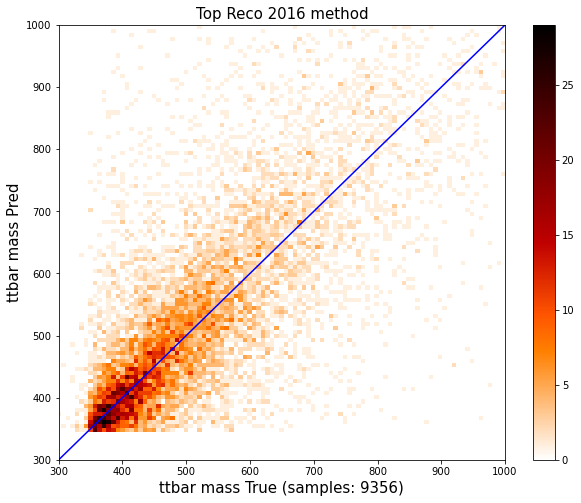

In [28]:
m_ttbar_red     = m_ttbar[:len(tt_mass)]
mask_reco       = m_ttbar_red < 1000
gen_m_ttbar_red = gen_m_ttbar[:len(tt_mass)]
mask_gen        = gen_m_ttbar_red < 1000
mask_fin        = mask_reco & mask_gen
samples         = len(m_ttbar_red[mask_fin])

heatmap,xedges,yedges =np.histogram2d(gen_m_ttbar_red[mask_fin] ,m_ttbar_red[mask_fin],bins=100)
extent  = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.figure(figsize=(10,8))
plt.imshow(heatmap.T ,extent=extent, origin='lower', aspect='auto')
plt.plot([0,1000],[0,1000],color='blue')
plt.set_cmap('gist_heat_r')
plt.xlabel("ttbar mass True (samples: %.i)" %samples, fontsize=15)
plt.ylabel("ttbar mass Pred", fontsize=15)
plt.title("Top Reco 2016 method" , fontsize=15)
plt.xlim(300,1000)
plt.ylim(300,1000)
plt.colorbar()
#plt.savefig('heatmap_2016_technique.jpg')

## PLOTTING UNITS

In [55]:
def cuts(datain, datacheck, minval, maxval):
    dataout = datain[np.logical_and(datacheck>minval,datacheck<maxval)]
    return(dataout)

def sem(values):
    sem     = stats.sem(values)
    return(sem)

def plotgaussian(resids,title):
    from matplotlib.pyplot import figure
    figure(figsize=(8, 6))
    resids.sort()
    resmean = np.mean(resids)
    resstd  = np.std(resids)
    pdf     = stats.norm.pdf(resids,resmean,resstd)
    
    plt.hist(resids,bins=50,histtype='step',color='blue',density=1,label='Residuals')
    plt.plot(resids,pdf,label="Normal Curve",color='black')
    plt.title(title)
    plt.xlim(-600,600)
    plt.axvline(resmean, label="Mean: %.2f" % resmean, color='red') 
    
    fwhm    = 2*np.sqrt(2*np.log(2))*resstd
    samples = len(resids)
    
    plt.xlabel("FWHM: %.2f (samples: %.i)" % (fwhm,samples))
    plt.axvspan(resmean-fwhm/2,resmean+fwhm/2,facecolor='g',alpha=.5,label='FWHM')
    plt.legend()

In [56]:
res.sort()
plt.figure(figsize=(8, 6))
pdf     = stats.norm.pdf(res[mi_mask] ,mean, std)

plt.hist(res[mi_mask], bins=30, histtype='step' ,color='blue',density=1,label='Residuals')
plt.plot(res[mi_mask], pdf, label="Normal Curve",color='black')
plt.xlim(-600,600)
plt.axvline(mean, label="Mean: %.2f" % mean, color='red') 

fwhm    = 2*np.sqrt(2*np.log(2))*std
samples = len(res[mi_mask])

plt.xlabel("FWHM: %.2f (samples: %.i)" % (fwhm,samples))
plt.axvspan(mean - fwhm/2, mean + fwhm/2,facecolor='g',alpha=.5,label='FWHM')
plt.legend()

NameError: name 'res' is not defined

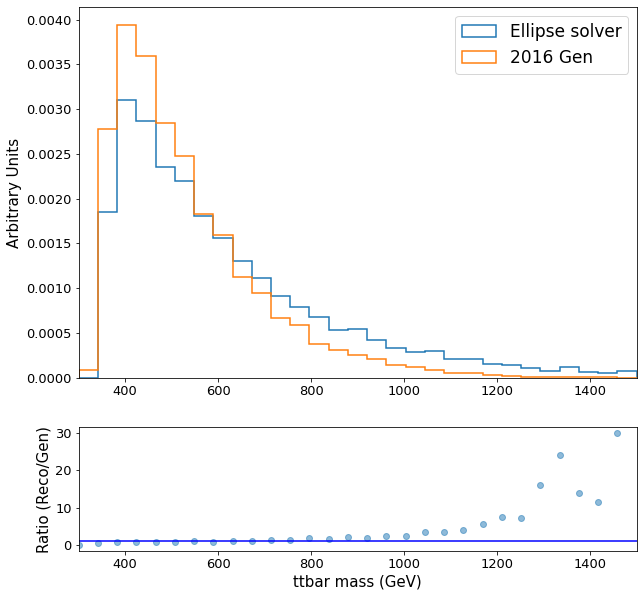

In [57]:
x_low    =  300
x_high   =  1500

binning = np.linspace(x_low,x_high, 30)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}

mask1    = tt_mass > 300
mask2    = tt_mass < 1500
mask_rec = mask1 & mask2

tt_gen_red = gen_m_ttbar[:len(tt_mass)]
mask_gen   = tt_gen_red < 1500

mask_fin   = mask_gen & mask_rec
fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(tt_mass[mask_fin]   , density=True, histtype='step', bins=binning, label='Ellipse solver', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_gen_red[mask_fin], density=True, histtype='step', bins=binning, label='2016 Gen', linewidth=1.5)

ax1.legend(prop={'size': 17}, loc='upper right')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
        ns1 / ns2,         # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Reco/Gen)', fontsize=15)
ax2.set_xlabel('ttbar mass (GeV)', fontsize=15)
#ax2.set_ylim(0, max(ns1/ns2))
ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

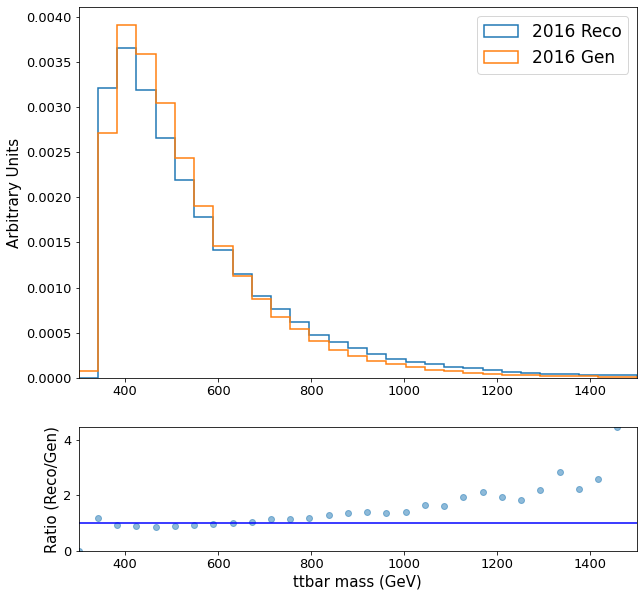

In [58]:
x_low    =  300
x_high   =  1500

binning = np.linspace(x_low,x_high, 30)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}

mask_rec   = m_ttbar < 1500
mask_gen   = gen_m_ttbar < 1500
mask_fin   = mask_rec & mask_gen

fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(m_ttbar[mask_fin]    , density=True, histtype='step', bins=binning, label='2016 Reco', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(gen_m_ttbar[mask_fin], density=True, histtype='step', bins=binning, label='2016 Gen' , linewidth=1.5)

ax1.legend(prop={'size': 17}, loc='upper right')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
        ns1 / ns2,         # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Reco/Gen)', fontsize=15)
ax2.set_xlabel('ttbar mass (GeV)', fontsize=15)
ax2.set_ylim(0, max(ns1/ns2))
ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

In [59]:
from scipy.stats import norm
def fit_gaussian(x):
    mean, std = norm.fit(x)
    return mean, std

def plot_gaussian(x, mean, std):
    x.sort()
    plt.figure(figsize=(10, 8))
    pdf = stats.norm.pdf(x ,mean, std)

    plt.hist(x, bins=30, histtype='step'     ,color='blue' ,density=1, label='Residuals')
    plt.plot(x, pdf    , label="Normal Curve",color='black')
    plt.xlim(-800,800)
    plt.axvline(mean, label="Mean: %.2f" % mean, color='red') 

    fwhm    = 2*np.sqrt(2*np.log(2))*std
    samples = len(x)

    plt.xlabel("STD: %.2f (samples: %.i)" % (std,samples), fontsize=15)
    plt.ylabel('AU', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.axvspan(mean - fwhm/2, mean + fwhm/2,facecolor='g',alpha=.5,label='FWHM')
    plt.legend(fontsize=15)

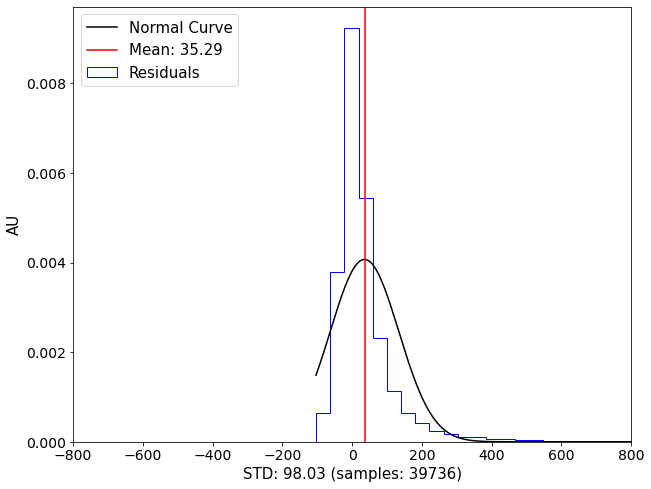

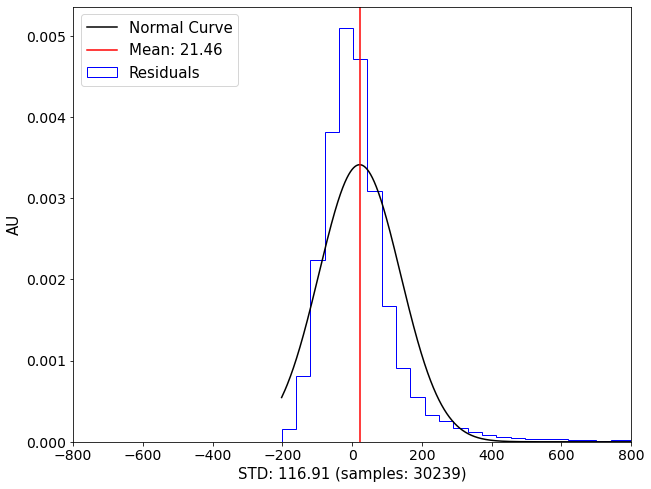

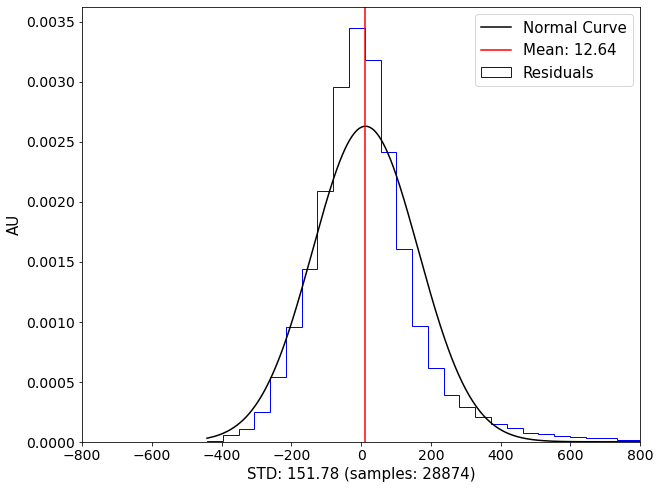

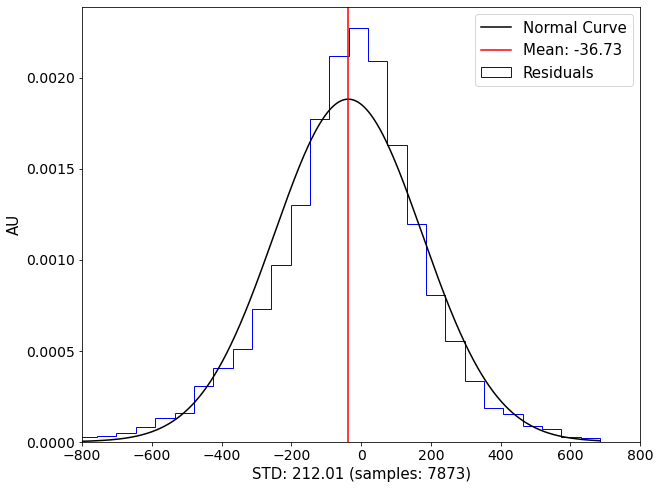

In [60]:
bins  = [0, 450, 550, 800, 1500]
width = []
err_x = []
err_y = []

mask_reco  = m_ttbar < 1500
mask_gen   = gen_m_ttbar < 1500
mask_fin   = mask_reco & mask_gen
samples    = len(m_ttbar[mask_fin])

for i in range(len(bins) - 1) :
    residual  = m_ttbar[mask_fin] -  gen_m_ttbar[mask_fin]
    temp_res  = cuts(residual, gen_m_ttbar[mask_fin], bins[i], bins[i+1])
    temp_mask1 = temp_res < 1500
    temp_mask  = temp_mask1 
    mean, std  = fit_gaussian(temp_res[temp_mask]) 
    plot_gaussian(temp_res, mean, std)
    width.append(std)
    err_x.append((bins[i+1] - bins[i]) * 0.5)
    err_y.append(1./np.sqrt(len(temp_res)))

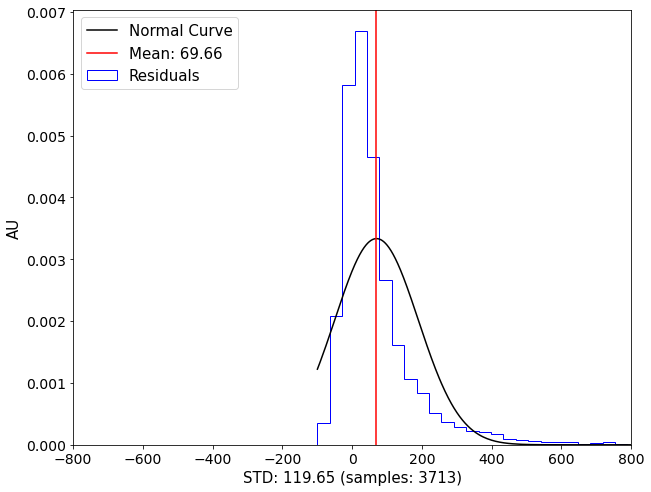

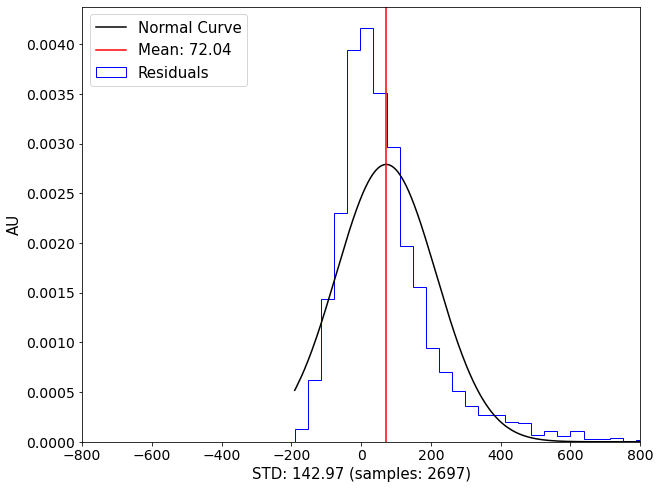

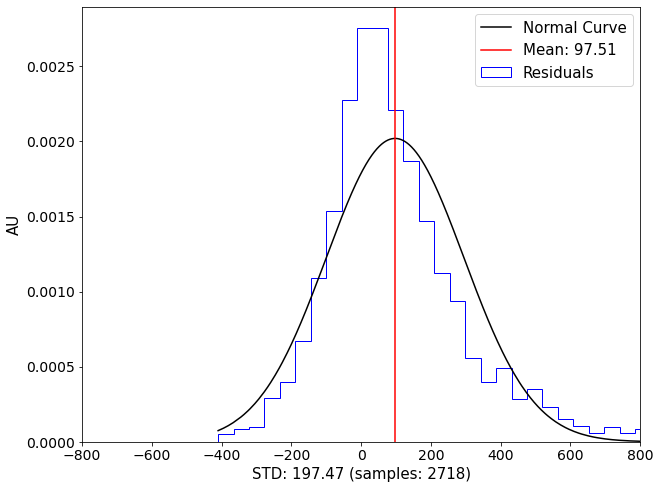

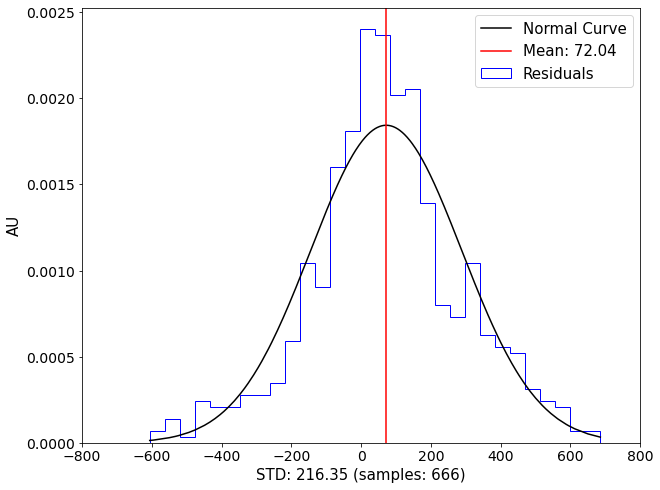

In [61]:
d_width = []
d_err_x = []
d_err_y = []
bin_centers = []

mask_reco1 = tt_mass < 1500
mask_reco2 = tt_mass > 0
mask_reco  = mask_reco1 & mask_reco2
mask_gen   = tt_gen_red < 1500
mask_fin   = mask_reco & mask_gen
samples    = len(tt_mass[mask_fin])

for i in range(len(bins) - 1) :
    residual  = tt_mass[mask_fin] -  tt_gen_red[mask_fin]
    temp_res  = cuts(residual, tt_gen_red[mask_fin] , bins[i], bins[i+1])
    temp_mask1 = temp_res < 1500
    temp_mask  = temp_mask1
    mean, std = fit_gaussian(temp_res[temp_mask]) 
    plot_gaussian(temp_res, mean, std)
    d_width.append(std)
    d_err_x.append((bins[i+1] - bins[i]) * 0.5)
    d_err_y.append(1./np.sqrt(len(temp_res)))
    bin_centers.append((bins[i] + bins[i+1]) * 0.5)

Text(0.5, 0, 'ttbar mass (GeV) ')

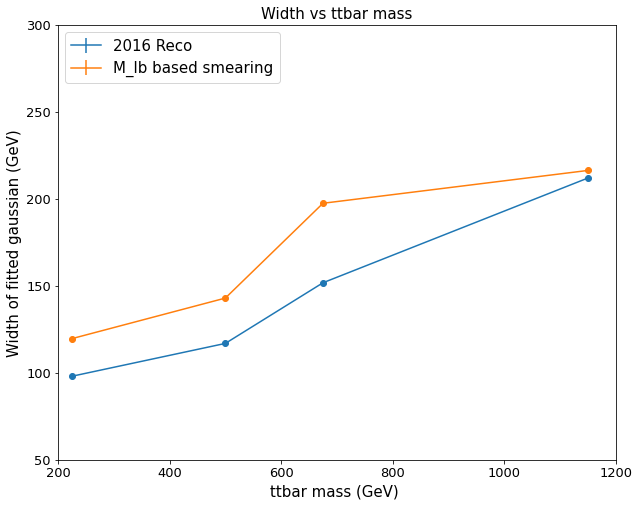

In [62]:
fig,axs = plt.subplots(figsize=(10,8))
axs.scatter(bin_centers , width)
axs.errorbar(bin_centers, width, yerr=err_y, label='2016 Reco')
axs.scatter(bin_centers , d_width)
axs.errorbar(bin_centers, d_width, yerr=d_err_y, label='M_lb based smearing')

axs.tick_params(axis='both', which='major', labelsize=13)
axs.legend(fontsize=15, loc='upper left')
axs.set_xlim(200, 1200)
axs.set_ylim(50 , 300)
axs.set_title("Width vs ttbar mass", fontsize=15)
axs.set_ylabel("Width of fitted gaussian (GeV)", fontsize=15)
axs.set_xlabel("ttbar mass (GeV) ", fontsize=15)


In [127]:
gen_b_pt  = step0_ptr['gen_b_pt'].array()
gen_b_eta = step0_ptr['gen_b_eta'].array()
gen_b_phi = step0_ptr['gen_b_phi'].array()

gen_l_pt  = step0_ptr['gen_l_pt'].array()
gen_l_eta = step0_ptr['gen_l_eta'].array()
gen_l_phi = step0_ptr['gen_l_phi'].array()

In [128]:
gen_bbar_pt  = step0_ptr['gen_bbar_pt'].array()
gen_bbar_eta = step0_ptr['gen_bbar_eta'].array()
gen_bbar_phi = step0_ptr['gen_bbar_phi'].array()

gen_lbar_pt  = step0_ptr['gen_lbar_pt'].array()
gen_lbar_eta = step0_ptr['gen_lbar_eta'].array()
gen_lbar_phi = step0_ptr['gen_lbar_phi'].array()

In [129]:
deta1 = abs(gen_b_eta) - abs(gen_lbar_eta)
deta2 = abs(gen_b_eta) - abs(gen_l_eta)

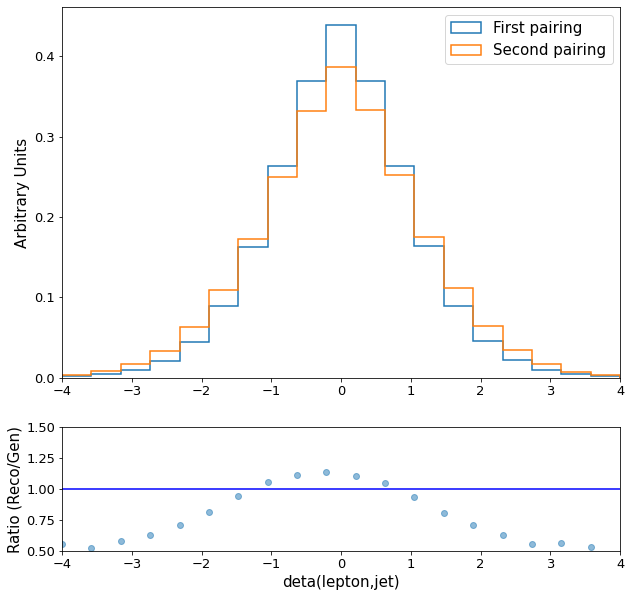

In [135]:
x_low    = -4
x_high   =  4

binning = np.linspace(x_low,x_high, 20)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}


fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(deta1, density=True, histtype='step', bins=binning, label='First pairing', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(deta2, density=True, histtype='step', bins=binning, label='Second pairing' , linewidth=1.5)

ax1.legend(prop={'size': 15}, loc='upper right')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
            ns1 / ns2,        # maybe check for div-by-zero!
            alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Reco/Gen)', fontsize=15)
ax2.set_xlabel('deta(lepton,jet)', fontsize=15)
ax2.set_ylim(0.5, 1.5)
ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

In [126]:
gen_t_pt      = tt_ptr['gen_top_pt'].array()
gen_t_eta     = tt_ptr['gen_top_rapidity'].array()
gen_t_phi     = tt_ptr['gen_top_phi'].array()

gen_tbar_pt   = tt_ptr['gen_tbar_pt'].array()
gen_tbar_eta  = tt_ptr['gen_tbar_rapidity'].array()
gen_tbar_phi  = tt_ptr['gen_tbar_phi'].array()

In [48]:
def ifOk(var_check) :
    if math.isfinite(var_check) :
        vOk = var_check
    else : 
        vOk = -999999.    
    return vOk

In [49]:
h_ckk = []
h_crr = []
h_cnn = []
h_crk = []
h_ckr = []
h_cnr = []
h_crn = []
h_cnk = []
h_ckn = []


for i in range(5000) :
    
    top    = ROOT.TLorentzVector()
    atop   = ROOT.TLorentzVector() 
    lep    = ROOT.TLorentzVector()
    alep   = ROOT.TLorentzVector()
    
    #top.SetPtEtaPhiM(tt_t_pt[i]    , tt_t_eta[i]   , tt_t_phi[i]   , 172.5)
    #atop.SetPtEtaPhiM(tt_tbar_pt[i], tt_tbar_eta[i], tt_tbar_phi[i], 172.5)  

    top.SetPtEtaPhiM(top_pt[i]  , top_eta[i] , top_phi[i] , 172.5)
    atop.SetPtEtaPhiM(atop_pt[i], atop_eta[i], atop_phi[i], 172.5) 
    
    lep.SetPtEtaPhiM(tt_l_pt[i]    , tt_l_eta[i]   , tt_l_phi[i]    , 0.0)
    alep.SetPtEtaPhiM(tt_lbar_pt[i], tt_lbar_eta[i], tt_lbar_phi[i] , 0.0)
    
    # Adapted from https://gitlab.cern.ch/cms-desy-top/TopAnalysis/Configuration/analysis/diLeptonic/src/VariablesPhiTT.cc
    
    # The various Bernreuther bases
    kBase = ROOT.TVector3()
    jBase = ROOT.TVector3()
    qBase = ROOT.TVector3()
    #rBase = ROOT.TVector3()
    #nBase = ROOT.TVector3()
    
    # Beam unit vector
    p3_pPro = ROOT.TVector3(0., 0., 1.)
    
    # The bases definition: Bernreuther spinMatrix 1508.05271
    p4_TT   = top + atop
    b4_TT   = ROOT.TVector3(-1. * p4_TT.BoostVector() )
    
    b4_pTop = top
    b4_pTop.Boost( b4_TT )
    
    b4_aTop = atop
    b4_aTop.Boost( b4_TT )
    
    # Maybe need to be careful with the signs here ?? Check how the pairings are implemented in the FW
    b4_aLep = alep
    b4_aLep.Boost( b4_TT )
    b4_aLep.Boost( -1. * b4_pTop.BoostVector() )
    
    b4_pLep = lep
    b4_pLep.Boost( b4_TT )
    b4_pLep.Boost( -1. * b4_aTop.BoostVector() )
    
    # Calculating the top-beam angle for pTop only
    c_pTP = b4_pTop.Vect().Unit().Dot(p3_pPro)
    s_pTP = np.sqrt(1. - (c_pTP * c_pTP))

    # The signs needed to account for Bose symmetry
    sY = 1. if ( c_pTP >= 0.) else -1.
    sD = 1. if ( abs(top.Rapidity()) >= abs(atop.Rapidity()) ) else -1. 

    # Define the base vectors a
    # j and q base are the k* and r* respectively
    # b is always -a
    
    kBase = b4_pTop.Vect().Unit()
    jBase = sD * kBase
    r_arr = (sY / s_pTP) * (p3_pPro - (c_pTP * kBase)) # Store in a temp np array since pyROOT typecasts automatically
    rBase = ROOT.TVector3(r_arr[0], r_arr[1], r_arr[2]).Unit()
    qBase = sD * rBase
    n_arr = (sY / s_pTP) *  p3_pPro.Cross(kBase)       # Store in a temp np array since pyROOT typecasts automatically
    nBase = ROOT.TVector3(n_arr[0], n_arr[1], n_arr[2]).Unit()

    # Find the relevant angles in these bases
    ck_aLep = b4_aLep.Vect().Unit().Dot( kBase )
    ck_pLep = b4_pLep.Vect().Unit().Dot( -1. * kBase )

    cj_aLep = b4_aLep.Vect().Unit().Dot( jBase )
    cj_pLep = b4_pLep.Vect().Unit().Dot( -1. * jBase )

    cr_aLep = b4_aLep.Vect().Unit().Dot( rBase )
    cr_pLep = b4_pLep.Vect().Unit().Dot( -1. * rBase )

    cq_aLep = b4_aLep.Vect().Unit().Dot( qBase )
    cq_pLep = b4_pLep.Vect().Unit().Dot( -1. * qBase )

    cn_aLep = b4_aLep.Vect().Unit().Dot( nBase )
    cn_pLep = b4_pLep.Vect().Unit().Dot( -1. * nBase )
    
    # spinCorr coeff Cab = -9<cab>
    ckk = ifOk( ck_aLep * ck_pLep )
    crr = ifOk( cr_aLep * cr_pLep )
    cnn = ifOk( cn_aLep * cn_pLep )

    crk = cr_aLep * ck_pLep
    ckr = ck_aLep * cr_pLep

    cnr = cn_aLep * cr_pLep
    crn = cr_aLep * cn_pLep

    cnk = cn_aLep * ck_pLep
    ckn = ck_aLep * cn_pLep
    
    h_ckk.append(ckk)
    h_crr.append(crr)
    h_cnn.append(cnn)
    h_crk.append(crk)
    h_ckr.append(ckr)
    h_cnr.append(cnr)
    h_crn.append(crn)
    h_cnk.append(cnk)
    h_ckn.append(ckn)

In [67]:
h_ckk_alt = []
h_crr_alt = []
h_cnn_alt = []
h_crk_alt = []
h_ckr_alt = []
h_cnr_alt = []
h_crn_alt = []
h_cnk_alt = []
h_ckn_alt = []


for i in range(5000) :
    
    top    = ROOT.TLorentzVector()
    atop   = ROOT.TLorentzVector() 
    lep    = ROOT.TLorentzVector()
    alep   = ROOT.TLorentzVector()
    
    top.SetPtEtaPhiM(tt_t_pt[i]    , tt_t_eta[i]   , tt_t_phi[i]   , 172.5)
    atop.SetPtEtaPhiM(tt_tbar_pt[i], tt_tbar_eta[i], tt_tbar_phi[i], 172.5)  
    
    lep.SetPtEtaPhiM(tt_l_pt[i]    , tt_l_eta[i]   , tt_l_phi[i]    , 0.0)
    alep.SetPtEtaPhiM(tt_lbar_pt[i], tt_lbar_eta[i], tt_lbar_phi[i] , 0.0)
    
    # Adapted from https://gitlab.cern.ch/cms-desy-top/TopAnalysis/Configuration/analysis/diLeptonic/src/VariablesPhiTT.cc
    
    # The various Bernreuther bases
    kBase = ROOT.TVector3()
    jBase = ROOT.TVector3()
    qBase = ROOT.TVector3()
    #rBase = ROOT.TVector3()
    #nBase = ROOT.TVector3()
    
    # Beam unit vector
    p3_pPro = ROOT.TVector3(0., 0., 1.)
    
    # The bases definition: Bernreuther spinMatrix 1508.05271
    p4_TT   = top + atop
    b4_TT   = ROOT.TVector3(-1. * p4_TT.BoostVector() )
    
    b4_pTop = top
    b4_pTop.Boost( b4_TT )
    
    b4_aTop = atop
    b4_aTop.Boost( b4_TT )
    
    # Maybe need to be careful with the signs here ?? Check how the pairings are implemented in the FW
    b4_aLep = alep
    b4_aLep.Boost( b4_TT )
    b4_aLep.Boost( -1. * b4_pTop.BoostVector() )
    
    b4_pLep = lep
    b4_pLep.Boost( b4_TT )
    b4_pLep.Boost( -1. * b4_aTop.BoostVector() )
    
    # Calculating the top-beam angle for pTop only
    c_pTP = b4_pTop.Vect().Unit().Dot(p3_pPro)
    s_pTP = np.sqrt(1. - (c_pTP * c_pTP))

    # The signs needed to account for Bose symmetry
    sY = 1. if ( c_pTP >= 0.) else -1.
    sD = 1. if ( abs(top.Rapidity()) >= abs(atop.Rapidity()) ) else -1. 

    # Define the base vectors a
    # j and q base are the k* and r* respectively
    # b is always -a
    
    kBase = b4_pTop.Vect().Unit()
    jBase = sD * kBase
    r_arr = (sY / s_pTP) * (p3_pPro - (c_pTP * kBase)) # Store in a temp np array since pyROOT typecasts automatically
    rBase = ROOT.TVector3(r_arr[0], r_arr[1], r_arr[2]).Unit()
    qBase = sD * rBase
    n_arr = (sY / s_pTP) *  p3_pPro.Cross(kBase)       # Store in a temp np array since pyROOT typecasts automatically
    nBase = ROOT.TVector3(n_arr[0], n_arr[1], n_arr[2]).Unit()

    # Find the relevant angles in these bases
    ck_aLep = b4_aLep.Vect().Unit().Dot( kBase )
    ck_pLep = b4_pLep.Vect().Unit().Dot( -1. * kBase )

    cj_aLep = b4_aLep.Vect().Unit().Dot( jBase )
    cj_pLep = b4_pLep.Vect().Unit().Dot( -1. * jBase )

    cr_aLep = b4_aLep.Vect().Unit().Dot( rBase )
    cr_pLep = b4_pLep.Vect().Unit().Dot( -1. * rBase )

    cq_aLep = b4_aLep.Vect().Unit().Dot( qBase )
    cq_pLep = b4_pLep.Vect().Unit().Dot( -1. * qBase )

    cn_aLep = b4_aLep.Vect().Unit().Dot( nBase )
    cn_pLep = b4_pLep.Vect().Unit().Dot( -1. * nBase )
    
    # spinCorr coeff Cab = -9<cab>
    ckk = ifOk( ck_aLep * ck_pLep )
    crr = ifOk( cr_aLep * cr_pLep )
    cnn = ifOk( cn_aLep * cn_pLep )

    crk = cr_aLep * ck_pLep
    ckr = ck_aLep * cr_pLep

    cnr = cn_aLep * cr_pLep
    crn = cr_aLep * cn_pLep

    cnk = cn_aLep * ck_pLep
    ckn = ck_aLep * cn_pLep
    
    h_ckk_alt.append(ckk)
    h_crr_alt.append(crr)
    h_cnn_alt.append(cnn)
    h_crk_alt.append(crk)
    h_ckr_alt.append(ckr)
    h_cnr_alt.append(cnr)
    h_crn_alt.append(crn)
    h_cnk_alt.append(cnk)
    h_ckn_alt.append(ckn)

In [50]:
tt_ckk   = tt_ptr['c_kk'].array()
tt_cnn   = tt_ptr['c_nn'].array()
tt_crr   = tt_ptr['c_rr'].array()
tt_crk   = tt_ptr['c_rk'].array()
tt_ckr   = tt_ptr['c_kr'].array()
tt_cnr   = tt_ptr['c_nr'].array()
tt_crn   = tt_ptr['c_rn'].array()

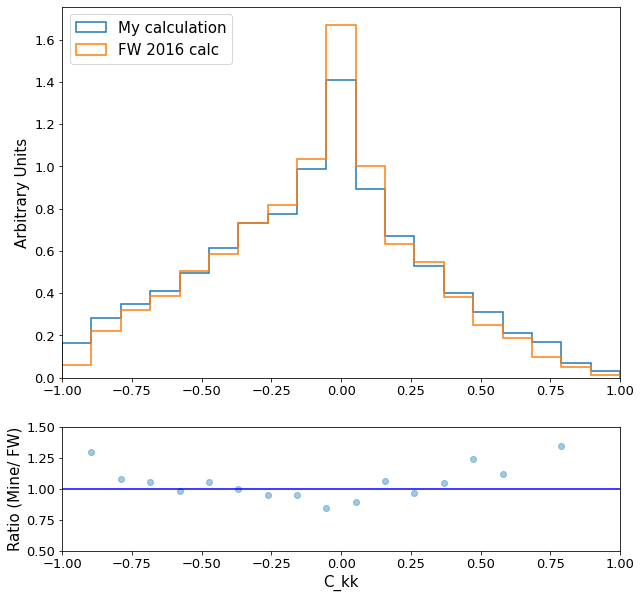

In [54]:
x_low    =  -1
x_high   =   1

binning = np.linspace(x_low,x_high, 20)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}


fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(h_cnn , density=True, histtype='step', bins=binning, label='My calculation', linewidth=1.5)
#ns1, bins1, patches  = ax1.hist(h_ckk_alt[:10000], density=True, histtype='step', bins=binning, label='My calc but 4 vec from FW', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_cnn[:len(tt_mass)], density=True, histtype='step', bins=binning, label='FW 2016 calc', linewidth=1.5)

ax1.legend(prop={'size': 15}, loc='upper left')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
        ns1 / ns2,         # maybe check for div-by-zero!
        alpha=0.4)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Mine/ FW)', fontsize=15)
ax2.set_xlabel('C_kk', fontsize=15)
ax2.set_ylim(0.5,1.5)
ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

In [62]:
step0_ptr     = uproot.open('/Volumes/Seagate Portable Media 1/CMS_data/ee_with_METphi.root')['ttBar_treeVariables_step0']
  
step0_gen_top_pt   = step0_ptr['gen_top_pt'].array()
step0_gen_top_eta  = step0_ptr['gen_top_rapidity'].array()
step0_gen_top_phi  = step0_ptr['gen_top_phi'].array()

step0_gen_tbar_pt  = step0_ptr['gen_tbar_pt'].array()
step0_gen_tbar_eta = step0_ptr['gen_tbar_rapidity'].array()
step0_gen_tbar_phi = step0_ptr['gen_tbar_phi'].array()

step0_gen_nu_pt    = step0_ptr['gen_nu_pt'].array()
step0_gen_nu_eta   = step0_ptr['gen_nu_eta'].array()
step0_gen_nu_phi   = step0_ptr['gen_nu_phi'].array()

step0_gen_nubar_pt    = step0_ptr['gen_nubar_pt'].array()
step0_gen_nubar_eta   = step0_ptr['gen_nubar_eta'].array()
step0_gen_nubar_phi   = step0_ptr['gen_nubar_phi'].array()

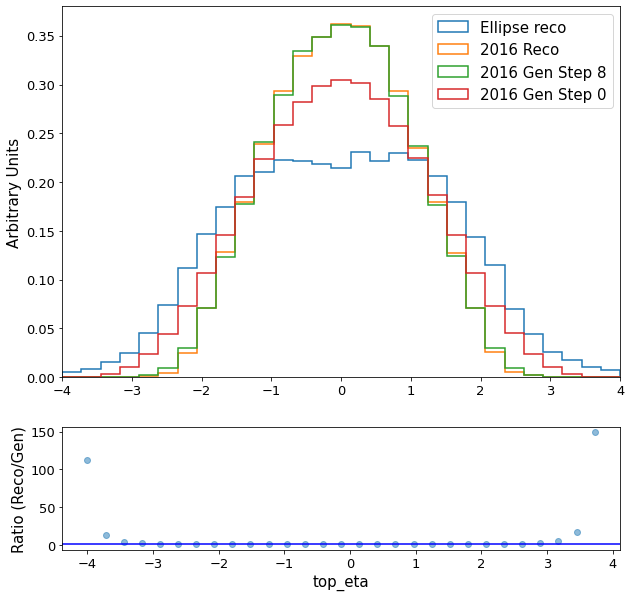

In [65]:
x_low    =  -4
x_high   =   4

binning = np.linspace(x_low,x_high, 30)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}

fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(top_eta, density=True, histtype='step', bins=binning, label='Ellipse reco', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_t_eta, density=True, histtype='step', bins=binning, label='2016 Reco', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_gen_top_eta, density=True, histtype='step', bins=binning, label='2016 Gen Step 8', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(step0_gen_top_eta, density=True, histtype='step', bins=binning, label='2016 Gen Step 0', linewidth=1.5)

ax1.legend(prop={'size': 15}, loc='upper right')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
        ns1 / ns2,         # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Reco/Gen)', fontsize=15)
ax2.set_xlabel('top_eta', fontsize=15)
#ax2.set_ylim(0.5, 1.5)
#ax2.set_ylim(0, max(ns1/ns2))
#ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

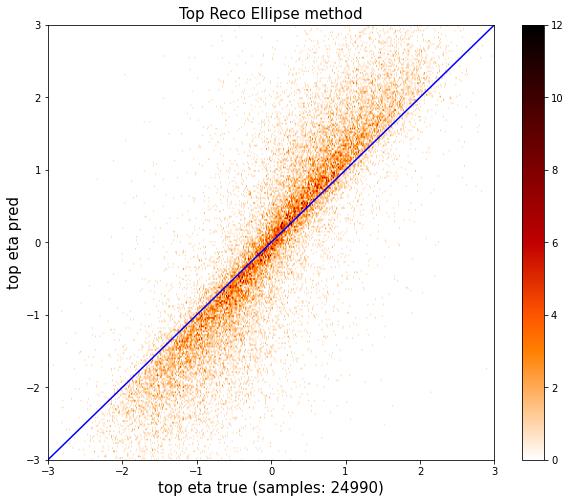

In [109]:
top_eta         = np.array(top_eta)
tt_gen_eta_red  = tt_gen_top_eta[:len(top_eta)]
mask_reco       = abs(top_eta) < 5
mask_gen        = abs(tt_gen_eta_red) < 5
mask_fin        = mask_reco & mask_gen
samples         = len(tt_gen_eta_red[mask_fin])

xlow = -3
xhigh = 3

heatmap,xedges,yedges = np.histogram2d(tt_gen_eta_red, top_eta ,bins=500)
extent  = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.figure(figsize=(10,8))
plt.imshow(heatmap.T ,extent=extent, origin='lower', aspect='auto')
plt.plot([xlow,xhigh],[xlow,xhigh],color='blue')
plt.set_cmap('gist_heat_r')
plt.xlabel("top eta true (samples: %.i)" %samples , fontsize=15)
plt.ylabel("top eta pred", fontsize=15)
plt.title("Top Reco Ellipse method" , fontsize=15)
plt.xlim(xlow,xhigh)
plt.ylim(xlow,xhigh)
plt.colorbar()

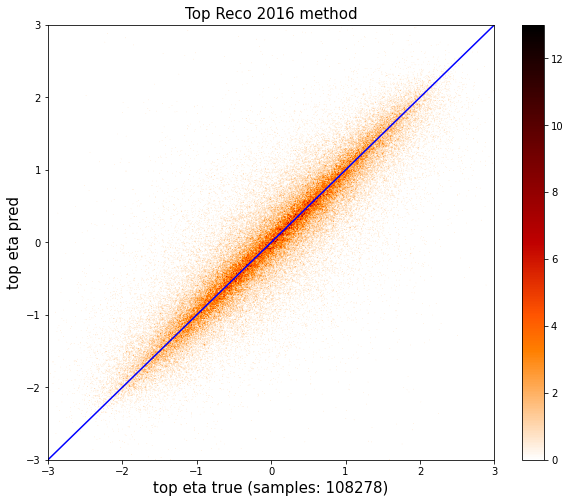

In [108]:
mask_reco       = abs(tt_t_eta) < 5
mask_gen        = abs(tt_gen_top_eta) < 5
mask_fin        = mask_reco & mask_gen
samples         = len(tt_t_eta[mask_fin])

xlow  = -3
xhigh =  3

heatmap,xedges,yedges = np.histogram2d(tt_gen_top_eta[mask_fin], tt_t_eta[mask_fin],bins=1000)
extent  = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.figure(figsize=(10,8))
plt.imshow(heatmap.T ,extent=extent, origin='lower', aspect='auto')
plt.plot([xlow,xhigh],[xlow,xhigh],color='blue')
plt.set_cmap('gist_heat_r')
plt.xlabel("top eta true (samples: %.i)" %samples, fontsize=15)
plt.ylabel("top eta pred", fontsize=15)
plt.title("Top Reco 2016 method" , fontsize=15)
plt.xlim(xlow,xhigh)
plt.ylim(xlow,xhigh)
plt.colorbar()

In [ ]:
''''
dr1 = dR(jet1.Phi(), jet1.Eta(), lep1.Phi(), lep1.Eta()) + dR(jet2.Phi(), jet2.Eta(), lep2.Phi(), lep2.Eta())
dr2 = dR(jet1.Phi(), jet1.Eta(), lep2.Phi(), lep2.Eta()) + dR(jet2.Phi(), jet2.Eta(), lep1.Phi(), lep1.Eta())

print('Smeared attempt pairing 1 :: ' + str(try_smear(jet1,jet2, lep1, lep2, met_x, met_y)) + ' dR :: ' + str(dr1))
print('Smeared attempt pairing 2 :: ' + str(try_smear(jet1,jet2, lep2, lep1, met_x, met_y)) + ' dR :: ' + str(dr2))
print('Gen m_ttbar :: ' + str(gen_m_ttbar[idx]))
print('M_ttbar     :: ' + str(m_ttbar[idx]))
'''

In [ ]:
'''
# Implemented from https://gitlab.cern.ch/TopAnalysis/Configuration/analysis/common/src/KinematicReconstruction.cc

def try_smear(jet1, jet2, lep1, lep2, metx, mety, evt_idx) :
    
    v_weights    = []
    vlv_tops     = []
    vlv_antitops = []
    vlv_nus      = []
    vlv_nubars   = []
    
    if  ( ((lep1 + jet1).M() > 180) or ((jet2 + lep2).M() > 180) ) : 
        zero_lv = ROOT.TLorentzVector()  
        return -999, zero_lv, zero_lv, zero_lv, zero_lv
    
    # Define met, not sure what Vx is
    met     = ROOT.TVector3(metx, mety ,0)
    vX_reco = - jet1.Vect() - jet2.Vect() - lep1.Vect() - lep2.Vect() - met
    
    for i in range(100) :
        
        met_sm  = ROOT.TLorentzVector()
        jet1_sm = ROOT.TLorentzVector(jet1)
        jet2_sm = ROOT.TLorentzVector(jet2)
        lep1_sm = ROOT.TLorentzVector(lep1)
        lep2_sm = ROOT.TLorentzVector(lep2)
        
        metV3_sm = ROOT.TVector3()
        
        # Jet energy based smearing 
        #fB1 = np.random.uniform(low= 1.0, high=1.04) # From Jet Energy Resolution
        fB1 = np.random.normal(1.0, 0.15)             # Changed from 0.15 to 0.10 for testing
        xB1 = np.sqrt((fB1**2 * jet1_sm.E()**2 - jet1_sm.M2()) / (jet1_sm.P() ** 2))

        jet1_sm.SetXYZT(jet1_sm.Px()*xB1, jet1_sm.Py()*xB1, jet1_sm.Pz()*xB1, jet1_sm.E()*fB1)
        angle_rot(0.001, jet1_sm)

        #fB2 = np.random.uniform(low= 1.0, high=1.04) # From Jet Energy Resolution
        fB2 = np.random.normal(1.0, 0.15)
        xB2 = np.sqrt((fB2**2 * jet2_sm.E()**2  - jet2_sm.M2()) / (jet2_sm.P() ** 2))

        jet2_sm.SetXYZT(jet2_sm.Px()*xB2, jet2_sm.Py()*xB2, jet2_sm.Pz()*xB2, jet2_sm.E()*fB2)
        angle_rot(0.001, jet2_sm)

        # Lepton energy based smearing 
        #fL1 = np.random.uniform(low= 1.0, high=1.02) # From Lep Energy Resolution
        fL1 = np.random.normal(1.0, 0.03)             
        xL1 = np.sqrt((fL1**2 * lep1_sm.E()**2  - lep1_sm.M2()) / (lep1_sm.P() ** 2))

        lep1_sm.SetXYZT(lep1_sm.Px()*xB1, lep1_sm.Py()*xB1, lep1_sm.Pz()*xB1, lep1_sm.E()*fB1)
        angle_rot(0.001, lep1_sm)

        #fL2 = np.random.uniform(low= 1.0, high=1.02) # From Lep Energy Resolution,
        fL2 = np.random.normal(1.0, 0.03)  
        xL2 = np.sqrt((fL2**2 * lep2_sm.E()**2  - lep2_sm.M2()) / (lep2_sm.P() ** 2))

        lep2_sm.SetXYZT(lep2_sm.Px()*xB2, lep2_sm.Py()*xB2, lep2_sm.Pz()*xB2, lep2_sm.E()*fB2)
        angle_rot(0.001, lep2_sm)

        # Adjust MET so that it is still balanced
        metV3_sm = -jet1_sm.Vect() - jet2_sm.Vect() - lep1_sm.Vect() - lep2_sm.Vect()- vX_reco
        met_sm.SetXYZM(metV3_sm.Px(),metV3_sm.Py(),0,0)

        #Maybe see if a solution exists or not
        try    :
            d       = doubleNeutrinoSolutions(jet1_sm, jet2_sm, lep1_sm, lep2_sm, met_sm.Px(), met_sm.Py())
            nu1     = Convertnuto4vec(d.nunu_s, 0, 0)
            nubar1  = Convertnuto4vec(d.nunu_s, 0, 1)
            
            top1    = jet1_sm + lep1_sm + nu1
            top2    = jet2_sm + lep2_sm + nubar1
            
            if (len(d.nunu_s) >= 2) :
                nu2     = Convertnuto4vec(d.nunu_s, 1, 0)
                nubar2  = Convertnuto4vec(d.nunu_s, 1, 1)

                deta_1  = abs(nu1.Eta()    - tt_gen_nu_eta[evt_idx])
                deta_2  = abs(nubar1.Eta() - tt_gen_nubar_eta[evt_idx])

                deta_3  = abs(nu2.Eta()    - tt_gen_nu_eta[evt_idx])
                deta_4  = abs(nubar2.Eta() - tt_gen_nubar_eta[evt_idx])
                
                if (deta_3 + deta_4) < (deta_1 + deta_2) :
                    nu_final    = nu2
                    nubar_final = nubar2
                    top_final   = jet1_sm + lep1_sm + nu2
                    atop_final  = jet2_sm + lep2_sm + nubar2
                    
                else : 
                    nu_final    = nu1
                    nubar_final = nubar1
                    top_final  = jet1_sm + lep1_sm + nu1
                    atop_final = jet2_sm + lep2_sm + nubar1
                    
            else :
                nu_final    = nu1
                nubar_final = nubar1
                top_final   = top1
                atop_final  = top2
                
            evt_w = get_mlb_weight(jet1_sm, lep1_sm) * get_mlb_weight(jet2_sm, lep2_sm)
            
            v_weights.append(evt_w)
            vlv_nus.append(nu_final)
            vlv_nubars.append(nubar_final)
            vlv_tops.append(top_final)
            vlv_antitops.append(atop_final)
            
        except np.linalg.LinAlgError : pass
        
    if len(v_weights) == 0 : 
        zero_lv = ROOT.TLorentzVector()   
        return -999, zero_lv, zero_lv, zero_lv, zero_lv
        
    else :
        mean_top_sol     = get_mean_sol(vlv_tops    , v_weights, 172.5)
        mean_antitop_sol = get_mean_sol(vlv_antitops, v_weights, 172.5)
        mean_nu_sol      = get_mean_sol(vlv_nus     , v_weights, 0)
        mean_nubar_sol   = get_mean_sol(vlv_nubars  , v_weights, 0)
        ttbar_mass       = (mean_top_sol + mean_antitop_sol).M()
        
        return ttbar_mass, mean_top_sol, mean_antitop_sol, mean_nu_sol, mean_nubar_sol
'''